In [1]:
# resources

# https://docs.llamaindex.ai/en/stable/examples/multi_modal/llava_multi_modal_tesla_10q/
# https://github.com/run-llama/llama_index/blob/main/docs/docs/examples/multi_modal/llava_multi_modal_tesla_10q.ipynb
# https://llamahub.ai/l/multi_modal_llms/llama-index-multi-modal-llms-replicate?from=multi_modal_llms
# https://github.com/kb3k/master-thesis-embeddings

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from unstructured.partition.html import partition_html
import pandas as pd

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

In [4]:
from llama_index.readers.file import FlatReader
from pathlib import Path

reader = FlatReader()
docs_2021 = reader.load_data(Path("tesla_2021_10k.htm"))

In [5]:
from llama_index.core.node_parser import UnstructuredElementNodeParser

node_parser = UnstructuredElementNodeParser()

In [6]:
import os

REPLICATE_API_TOKEN = ""  # Your Relicate API token here
os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN

In [7]:
import openai

OPENAI_API_KEY = ""
openai.api_key = OPENAI_API_KEY  # add your openai api key here
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [8]:
import nest_asyncio
nest_asyncio.apply() # to allow for asynchronous operations in node_parser function

In [9]:
import os
import pickle

if not os.path.exists("2021_nodes.pkl"):
    raw_nodes_2021 = node_parser.get_nodes_from_documents(docs_2021)
    pickle.dump(raw_nodes_2021, open("2021_nodes.pkl", "wb"))
else:
    raw_nodes_2021 = pickle.load(open("2021_nodes.pkl", "rb"))

In [10]:
nodes_2021, objects_2021 = node_parser.get_nodes_and_objects(raw_nodes_2021)

## Construct Retreivers

In [11]:
from llama_index.core import VectorStoreIndex

# construct top-level vector index + query engine
vector_index = VectorStoreIndex(nodes=nodes_2021, objects=objects_2021)
query_engine = vector_index.as_query_engine(similarity_top_k=2, verbose=True)

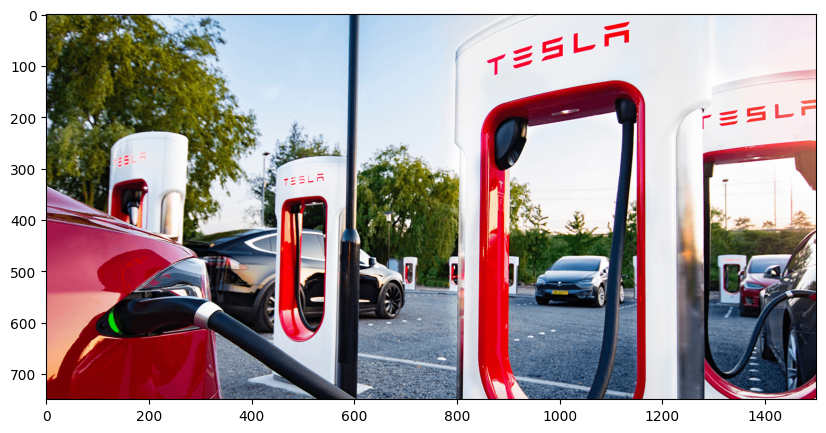

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

imageUrl = "./tesla_supercharger.jpg"
image = Image.open(imageUrl).convert("RGB")

plt.figure(figsize=(16, 5))
plt.imshow(image)

## Run LLaVa model using Replicate through LLama Index

In [13]:
from llama_index.multi_modal_llms.replicate import ReplicateMultiModal
from llama_index.core.schema import ImageDocument
from llama_index.multi_modal_llms.replicate.base import (
    REPLICATE_MULTI_MODAL_LLM_MODELS,
)

multi_modal_llm = ReplicateMultiModal(
    model=REPLICATE_MULTI_MODAL_LLM_MODELS["llava-13b"],
    max_new_tokens=200,
    temperature=0.1,
)

prompt = "what is the main object for tesla in the image?"

llava_response = multi_modal_llm.complete(
    prompt=prompt,
    image_documents=[ImageDocument(image_path=imageUrl)],
)

In [14]:
prompt_template = "please provide relevant information about: "
rag_response = query_engine.query(prompt_template + llava_response.text)

In [15]:
print(str(rag_response))

Tesla's main focus is on manufacturing electric vehicles, energy generation, and storage products. They have a global network of Tesla Superchargers, which are high-speed vehicle chargers placed along well-traveled routes and in dense city centers. These Supercharger stations are designed to provide quick, reliable, and convenient charging for Tesla vehicle owners. Tesla also collaborates with various businesses and locations to offer additional charging options through Destination Charging and workplace locations.


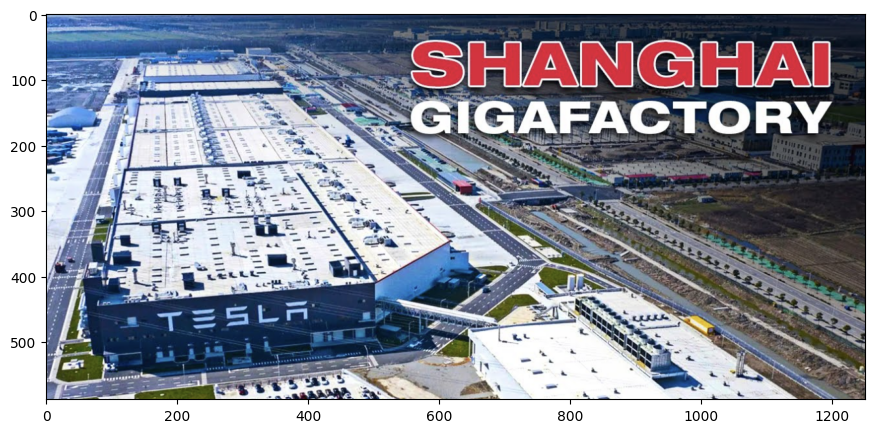

In [16]:
from PIL import Image
import matplotlib.pyplot as plt

imageUrl = "./shanghai.jpg"
image = Image.open(imageUrl).convert("RGB")

plt.figure(figsize=(16, 5))
plt.imshow(image)

In [17]:
prompt = "which Tesla factory is shown in the image?"

llava_response = multi_modal_llm.complete(
    prompt=prompt,
    image_documents=[ImageDocument(image_path=imageUrl)],
)

In [18]:
prompt_template = "please provide relevant information about: "
rag_response = query_engine.query(prompt_template + llava_response.text)

In [19]:
print(rag_response)

The Tesla Gigafactory in Sparks, Nevada is a significant manufacturing facility where battery material, cell, module, and battery pack production for Model 3, Model Y, and energy products take place. The facility also manufactures vehicle drive units and energy storage components. Tesla entered into agreements with the State of Nevada and Storey County in Nevada to receive tax incentives, abatements for specified taxes, discounts on energy rates, and transferable tax credits in consideration of capital investment and hiring targets met at Gigafactory Nevada. These incentives are available until June 2024 or June 2034, depending on the specific incentive.


In [28]:
prompt = "which Tesla factory is shown in the image? Is it Shanghai or Nevada? How did you figure it out?"

llava_response = multi_modal_llm.complete(
    prompt=prompt,
    image_documents=[ImageDocument(image_path=imageUrl)],
)

prompt_template = "please provide relevant information about: "
rag_response = query_engine.query(prompt_template + llava_response.text)

In [29]:
print(rag_response)

The image depicts the Tesla factory in Shanghai, China, recognizable by the large building with a red sign on top, which is a distinctive feature of the Gigafactory Shanghai. The presence of numerous cars and trucks in the parking lot and the overall layout of the factory further indicate that it is indeed the Shanghai Gigafactory.
